In [1]:
# nn model is SUPERVISED -> regression (we want to predict coordinates)

In [2]:
# import math libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [3]:
# read from the csv file
location = pd.read_csv("Observations_autoparts.csv")
df = pd.DataFrame(location)
df = df.astype('float32')

# split to x and y
x = df[["rssi_antenna1", "rssi_antenna2", "rssi_antenna3", "rssi_antenna4", "rc_antenna1", "rc_antenna2", "rc_antenna3", "rc_antenna4"]]
y = df[["true_x", "true_y"]]

# train-test split (raw data)
x_train_raw, x_test_raw, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=6)

# standardize the data
scaler = StandardScaler()
scaler.fit(x_train_raw)
x_train = scaler.transform(x_train_raw)
x_test = scaler.transform(x_test_raw)

# pre-transform the data before feeding it to the DataLoader
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train.to_numpy()))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test.to_numpy()))


# load the data into training and test
# shuffle ->  we don't want the model to overfit the data and get used to order 
loaders ={
    "train" : DataLoader(train_data, batch_size=128, shuffle=True),
    "test" : DataLoader(test_data, batch_size=len(test_data), shuffle=False)
}

In [4]:
# define the ANN model
class ANN(nn.Module):
    def __init__(self):
        """
        INPUT: 8 neurons
        HIDDEN LAYERS (3): 25 neurons, 50 neurons, 6 neurons
        OUTPUT: 2 neurons

        forward() -> returns the output of the forward pass (x, y prediction)
        """
        # call the nn.Module parent
        super(ANN, self).__init__()

        # linear and relu (since our task is regression)
        self.linear1 = nn.Linear(8, 25) 
        self.linear2 = nn.Linear(25, 50)
        self.linear3 = nn.Linear(50, 6)
        self.output = nn.Linear(6, 2)

    # how our data will pass through the network
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.output(x)

        return x

In [5]:
# instantiate the model
model = ANN()

# set a loss function and an optimizer funciton
loss_fn = nn.MSELoss()  # Mean Squared Error Loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # our learning rate is 0.001, and weight decay for L2

In [12]:
# train the model
num_of_epochs = 100
for epoch in range(num_of_epochs):
    # print out every 10th epoch 
    if(epoch % 10 == 0):
        print(f"Epoch: {epoch}/{num_of_epochs}")

    for data, labels in loaders["train"]:
        optimizer.zero_grad()
        outputs = model(data)

        # Print shapes for verification
        # print(f"Outputs shape: {outputs.shape}")
        # print(f"Labels shape: {labels.shape}")

        # calculate loss
        loss = loss_fn(outputs, labels)

        loss.backward() 
        optimizer.step()


Epoch: 0/100
Epoch: 10/100
Epoch: 20/100
Epoch: 30/100
Epoch: 40/100
Epoch: 50/100
Epoch: 60/100
Epoch: 70/100
Epoch: 80/100
Epoch: 90/100


In [7]:
# test and evaluate the model's error  
error = 0
with torch.no_grad():
    for data, labels, in loaders["test"]:
        outputs = model(data)

        # store the predicted x and y values
        predicted_x = outputs[:,0]
        predicted_y = outputs[:,1]

        # calculate the mean error squared
        error += nn.functional.mse_loss(outputs, labels).item()

error /= len(loaders["test"].dataset)

# print out the error and accuracy
print(f"Mean Squared Error: {error}")
# the goal is to have a small error value

Mean Squared Error: 0.045376117706298826


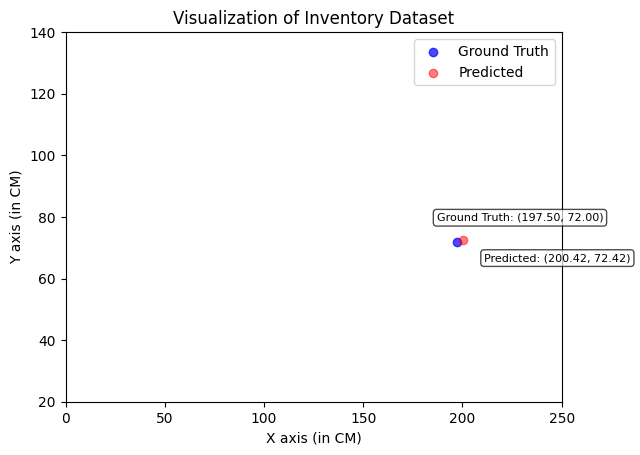

In [8]:
# add a matplotlib visualization of the item in a 3d space
# get the xy predictions and split them up
# PREDICTED INDEXES: 11, 19
predicted_index = 11

fig = plt.figure()
ax = fig.add_subplot(111)

# one point
scatter_gt = ax.scatter(labels[predicted_index, 0], labels[predicted_index, 1], c="blue", label="Ground Truth", alpha=0.7)  # printing one ground truth
scatter_pred = ax.scatter(predicted_x[predicted_index], predicted_y[predicted_index], c="red", label="Predicted", alpha=0.5)  # printing one predicted value

# # whole graph
# scatter_gt = ax.scatter(labels[:, 0], labels[:, 1], c="blue", label="Ground Truth", alpha=0.7)
# scatter_pred = ax.scatter(predicted_x, predicted_y, c="red", label="Predicted", alpha=0.5)


## ANNOTATING POINTS
ax.annotate(f"Predicted: ({predicted_x[predicted_index]:.2f}, {predicted_y[predicted_index]:.2f})",
            (predicted_x[predicted_index], predicted_y[predicted_index]),
            xytext=(15, -15),  # Adjust offset for better placement
            textcoords="offset points",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

ax.annotate(f"Ground Truth: ({labels[predicted_index, 0]:.2f}, {labels[predicted_index, 1]:.2f})",
            (labels[predicted_index, 0], labels[predicted_index, 1]),
            xytext=(-15, 15),  # Adjust offset for better placement
            textcoords="offset points",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
##


## SHOW FULL SCALE OF XY PLANE ##
ax.set_xlim(xmin=0, xmax=250)  # set x-axis limits from 0 to 250
ax.set_ylim(ymin=20, ymax=140)  # set y-axis limits from 20 to 140

# set label for the axes
ax.set_xlabel("X axis (in CM)")
ax.set_ylabel("Y axis (in CM)")

# set title
ax.set_title("Visualization of Inventory Dataset")

ax.legend()
plt.show()